In [134]:
import hopsworks
import pandas as pd
from sklearn.ensemble import IsolationForest

project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
Connected. Call `.close()` to terminate connection gracefully.


In [135]:
try: 
    feature_view = fs.get_feature_view(name="spot50", version=1)
except:
    fg = fs.get_feature_group(name="spot50", version=1)
    query = fg.select_all()
    feature_view = fs.create_feature_view(name="spot50",
                                      version=1,
                                      description="sensor 50",
                                      query=query)

In [136]:
feature, labels = feature_view.training_data(
    description = 'spot50 training dataset',
)

features = feature[['x','y','z','temperature','magnitude']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
2024-05-28 11:06:40,928 WARNING: VersionWarning: Incremented version to `5`.



In [137]:
# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.1) 

model.fit(features)

predictions = model.predict(features)

feature['anomaly'] = predictions

anomalies = feature[feature['anomaly'] == -1]
normal = feature[feature['anomaly'] == 1]


In [138]:
feature.anomaly.value_counts()

anomaly
 1    7339
-1     816
Name: count, dtype: int64

In [139]:
df = feature.sort_values(by='time')

In [140]:
anomalies = feature[feature['anomaly'] == -1]
anomalies_sorted = anomalies.sort_values(by='time')
anomalies_sorted

,id,time,temperature,x,y,z,magnitude,anomaly
699,49,2024-03-01 08:42:53.771000,0.095238,0.285636,0.349362,0.653209,0.512251,-1
4365,50,2024-03-01 08:43:11.111000,0.071429,0.237755,0.318940,0.656315,0.560607,-1
5558,51,2024-03-01 09:44:09.933000,0.285714,0.213539,0.260059,0.475155,0.535469,-1
6976,52,2024-03-01 09:58:56.933000,0.285714,0.212988,0.266928,0.473085,0.537407,-1
540,53,2024-03-01 10:13:48.933000,0.285714,0.214640,0.264966,0.476190,0.535226,-1
...,...,...,...,...,...,...,...,...
2417,8087,2024-04-29 11:23:31.706000,0.857143,0.189873,0.462218,0.317805,0.616217,-1
3494,8088,2024-04-29 11:38:20.706000,0.857143,0.190974,0.461237,0.312629,0.614480,-1
6396,8089,2024-04-29 11:38:31.649000,0.809524,0.189323,0.456330,0.314700,0.614695,-1
578,8090,2024-04-29 11:53:36.649000,0.809524,0.189323,0.456330,0.317805,0.614691,-1


In [141]:
non_anomalies = feature[feature['anomaly'] == 1]
non_anomalies_sorted = non_anomalies.sort_values(by='time')
non_anomalies_sorted

,id,time,temperature,x,y,z,magnitude,anomaly
6855,0,2024-03-01 00:14:23.138000,0.119048,0.362686,0.340530,0.397516,0.359387,1
564,1,2024-03-01 00:14:31.951000,0.119048,0.363786,0.338567,0.397516,0.357248,1
1686,2,2024-03-01 00:29:13.951000,0.119048,0.361585,0.343474,0.395445,0.361729,1
4367,3,2024-03-01 00:44:05.951000,0.119048,0.361585,0.342493,0.392340,0.360996,1
5736,4,2024-03-01 00:44:16.873000,0.142857,0.360484,0.336605,0.398551,0.360461,1
...,...,...,...,...,...,...,...,...
4370,8150,2024-04-29 23:05:19.588000,0.785714,0.352229,0.354269,0.405797,0.378527,1
5583,8151,2024-04-29 23:20:16.588000,0.785714,0.348376,0.355250,0.399586,0.382838,1
7611,8152,2024-04-29 23:35:03.588000,0.785714,0.348927,0.347399,0.397516,0.378669,1
331,8153,2024-04-29 23:35:15.296000,0.785714,0.348376,0.350343,0.405797,0.381441,1


In [142]:
import matplotlib.pyplot as plt


In [143]:
import pandas as pd

def update_time_format(df, column_name):
    
    # Add milliseconds to missing columns
    df[column_name] = df[column_name].apply(lambda x: x if x.count('.') == 1 else f"{x}.000")

    # Convert to datetime format
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m-%d %H:%M:%S.%f')

    return df

df = update_time_format(df, 'time')


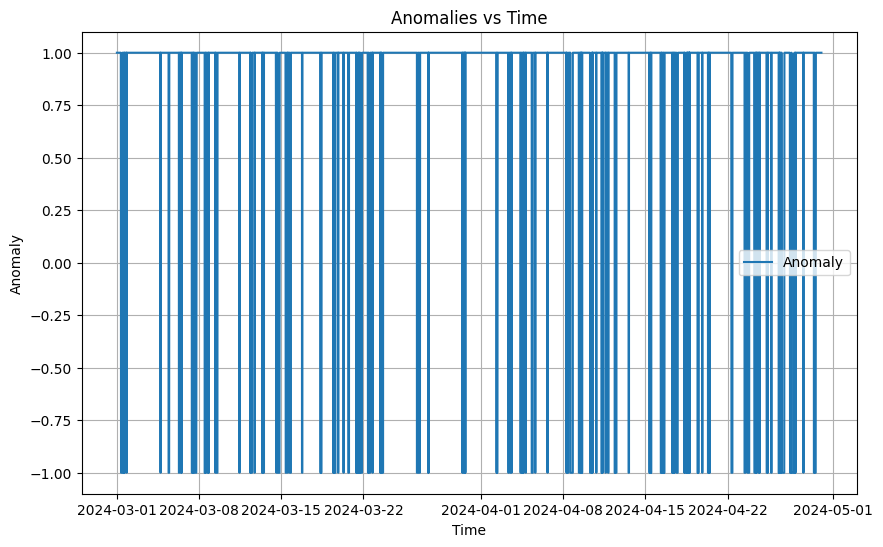

In [144]:
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['anomaly'], label='Anomaly')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.title('Anomalies vs Time')
plt.legend()
plt.grid(True)
plt.show()

In [145]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import shutil


Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/816040 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/spot50_isolation_forrest/3


Model(name: 'spot50_isolation_forrest', version: 3)

Number of anomalies detected: 407


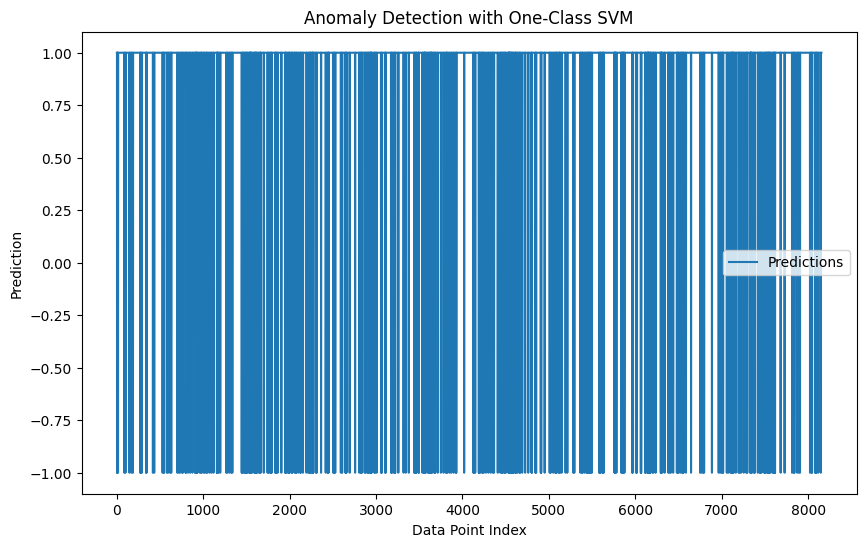

Anomaly indices: [   2    5   13   87   99  146  170  186  271  275  289  338  343  417
  431  432  529  541  545  578  593  616  629  699  716  732  755  763
  795  800  824  848  874  904  911  918  926  927  930  931  960  977
  979 1003 1017 1018 1036 1049 1074 1096 1118 1158 1161 1164 1176 1196
 1266 1280 1303 1325 1336 1445 1452 1461 1462 1480 1486 1501 1510 1529
 1538 1540 1546 1550 1564 1589 1597 1598 1601 1609 1617 1634 1656 1660
 1662 1700 1744 1755 1772 1785 1792 1834 1837 1847 1861 1903 1947 1952
 1964 1982 1995 1999 2023 2032 2060 2069 2070 2077 2100 2123 2129 2154
 2195 2214 2215 2216 2230 2239 2248 2265 2268 2271 2302 2314 2363 2417
 2442 2445 2448 2502 2503 2517 2527 2592 2607 2644 2651 2657 2694 2757
 2806 2824 2829 2837 2868 2881 2906 2908 2928 2934 2939 2942 2950 2983
 2986 3006 3057 3068 3105 3111 3173 3181 3199 3218 3220 3221 3257 3318
 3343 3378 3441 3450 3463 3465 3492 3494 3536 3552 3559 3563 3566 3570
 3594 3611 3617 3634 3636 3638 3657 3678 3683 3713 3750 3781

In [146]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt


model_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)

model_svm.fit(features)

predictions = model_svm.predict(features)

anomalies = predictions == -1
print(f"Number of anomalies detected: {np.sum(anomalies)}")

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions')
plt.xlabel('Data Point Index')
plt.ylabel('Prediction')
plt.title('Anomaly Detection with One-Class SVM')
plt.legend()
plt.show()

anomaly_indices = np.where(anomalies)[0]
print(f"Anomaly indices: {anomaly_indices}")


2024-05-28 11:09:31,773 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2024-05-28 11:09:31,886 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



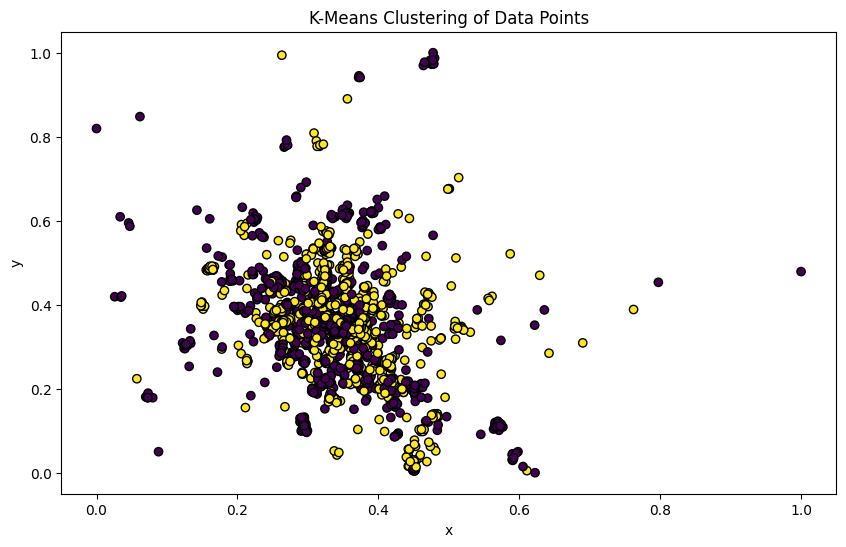

          x         y         z  temperature  magnitude  cluster
0  0.353330  0.347399  0.397516     0.500000   0.635253        0
1  0.369290  0.345437  0.401656     0.357143   0.645778        1
2  0.255916  0.376840  0.466874     0.976190   0.652283        0
3  0.338470  0.337586  0.404762     0.619048   0.626385        0
4  0.352779  0.349362  0.402692     0.642857   0.639271        0


In [147]:
from sklearn.cluster import KMeans


features['magnitude'] = np.sqrt(features['x']**2 + features['y']**2 + features['z']**2)

kmeans = KMeans(n_clusters=2, random_state=42)  

kmeans.fit(features)

clusters = kmeans.predict(features)

features['cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(features['x'], features['y'], c=features['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of Data Points')
plt.show()

print(features.head())

cluster_counts = features['cluster'].value_counts()
anomaly_cluster = cluster_counts.idxmin()

anomalies = features[features['cluster'] == anomaly_cluster]

anomaly_indices = anomalies.index


In [148]:
features.head(20)

,x,y,z,temperature,magnitude,cluster
0,0.353330,0.347399,0.397516,0.500000,0.635253,0
1,0.369290,0.345437,0.401656,0.357143,0.645778,1
2,0.255916,0.376840,0.466874,0.976190,0.652283,0
3,0.338470,0.337586,0.404762,0.619048,0.626385,0
4,0.352779,0.349362,0.402692,0.642857,0.639271,0
5,0.475509,0.972522,0.301242,0.476190,1.123679,0
6,0.364887,0.345437,0.400621,0.261905,0.642625,1
7,0.364887,0.344455,0.399586,0.142857,0.641452,1
8,0.356632,0.314033,0.397516,0.261905,0.619534,1
9,0.340121,0.335623,0.402692,0.595238,0.624889,0


In [151]:
mr = project.get_model_registry()

model_dir1="spot50_k_nn"
if os.path.isdir(model_dir1) == False:
    os.mkdir(model_dir1)
joblib.dump(kmeans, model_dir1 + "/spot50_k_nn.pkl")



spot50 = mr.python.create_model(
    version=1,
    name="spot50_k_nnt", 
    description="Anomaly detection- UML")

spot50.save(model_dir1)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/33779 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/spot50_k_nnt/1


Model(name: 'spot50_k_nnt', version: 1)